# k-Means Clustering

Nous allons maintenant passer à une autre catégorie de modèles d'apprentissage automatique non supervisés : les algorithmes de regroupement.
Les algorithmes de clustering cherchent à apprendre, à partir des propriétés des données, une division optimale ou un étiquetage discret de groupes de points.

De nombreux algorithmes de clustering sont disponibles dans Scikit-Learn et ailleurs, mais le plus simple à comprendre est peut-être un algorithme connu sous le nom de *k-means clustering*, qui est implémenté dans ``sklearn.cluster.KMeans``.

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()  # for plot styling
import numpy as np

L'algorithme *k*-means recherche un nombre prédéterminé de clusters dans un ensemble de données multidimensionnelles non étiquetées.
Pour ce faire, il utilise une conception simple de ce à quoi ressemble un regroupement optimal :

- Le "centre du cluster" est la moyenne arithmétique de tous les points appartenant au cluster.
- Chaque point est plus proche de son propre centre de cluster que des autres centres de cluster.

Ces deux hypothèses constituent la base du modèle *k*-means.
Nous verrons bientôt *comment* l'algorithme parvient à cette solution, mais pour l'instant, examinons un ensemble de données simple et voyons le résultat de *k*-means.

Tout d'abord, générons un ensemble de données bidimensionnel contenant quatre gouttes distinctes.
Pour souligner le fait qu'il s'agit d'un algorithme non supervisé, nous laisserons les étiquettes en dehors de la visualisation.

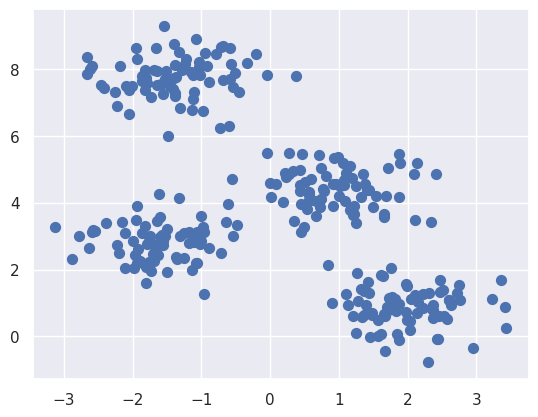

In [2]:
from sklearn.datasets import make_blobs
X, y_true = make_blobs(n_samples=300, centers=4,
                       cluster_std=0.60, random_state=0)
plt.scatter(X[:, 0], X[:, 1], s=50);

À l'œil, il est relativement facile de repérer les quatre clusters.
L'algorithme *k*-means le fait automatiquement :

In [3]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=4)
kmeans.fit(X)
y_kmeans = kmeans.predict(X)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Visualisons les résultats en traçant les données colorées par ces étiquettes.
Nous allons également tracer les centres des clusters tels que déterminés par l'estimateur *k*-means :

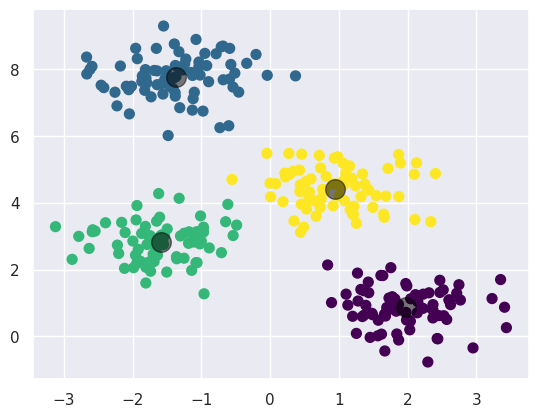

In [4]:
plt.scatter(X[:, 0], X[:, 1], c=y_kmeans, s=50, cmap='viridis')

centers = kmeans.cluster_centers_
plt.scatter(centers[:, 0], centers[:, 1], c='black', s=200, alpha=0.5);

La bonne nouvelle est que l'algorithme *k*-means (du moins dans ce cas simple) affecte les points aux groupes de manière très similaire à la manière dont nous pourrions les affecter à l'œil nu.

Mais vous pouvez vous demander comment cet algorithme trouve ces groupes si rapidement ! Après tout, le nombre de combinaisons possibles d'affectations de groupes est exponentiel par rapport au nombre de points de données - une recherche exhaustive serait très, très coûteuse.

Heureusement pour nous, une telle recherche exhaustive n'est pas nécessaire : au lieu de cela, l'approche typique des *k*-moyens implique une approche itérative intuitive connue sous le nom de *maximisation par espérance*.

## k-Means Algorithm: Expectation–Maximization

L'Expectation-Maximization (E-M) est un algorithme puissant qui intervient dans de nombreux contextes.
Les *k*-means sont une application particulièrement simple et facile à comprendre de l'algorithme, et nous allons la parcourir brièvement ici.
En bref, l'approche de l'expectation-maximisation consiste ici en la procédure suivante :

1. Devinez quelques centres de clusters
2. Répéter jusqu'à la convergence
   1. *E-étape* : assigner des points au centre de cluster le plus proche
   2. *M-Step* : définir les centres de cluster à la moyenne

Ici, l'étape "E" ou "étape d'espérance" est ainsi nommée parce qu'elle implique la mise à jour de notre espérance de l'appartenance de chaque point à un cluster.
L'"étape M" ou "étape de maximisation" est ainsi nommée parce qu'elle implique la maximisation d'une certaine fonction de pertinence qui définit l'emplacement des centres de cluster - dans ce cas, cette maximisation est accomplie en prenant une moyenne simple des données dans chaque cluster.

La littérature sur cet algorithme est vaste, mais peut être résumée comme suit : dans des circonstances typiques, chaque répétition de l'étape E et de l'étape M aboutira toujours à une meilleure estimation des caractéristiques des clusters.

Nous pouvons visualiser l'algorithme comme indiqué dans la figure suivante.
Pour l'initialisation particulière présentée ici, les clusters convergent en seulement trois itérations.

L'algorithme *k*-Means est suffisamment simple pour que nous puissions l'écrire en quelques lignes de code.
Ce qui suit est une implémentation très basique :

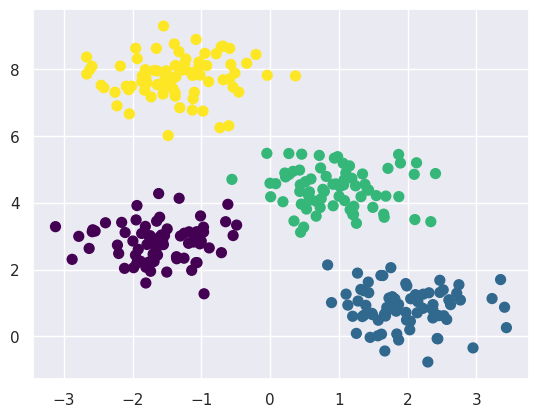

In [5]:
from sklearn.metrics import pairwise_distances_argmin

def find_clusters(X, n_clusters, rseed=42):

    # Randomly choose clusters
    rng = np.random.RandomState(rseed)
    i = rng.permutation(X.shape[0])[:n_clusters]
    centers = X[i]

    while True:
        # Assign labels based on closest center
        labels = pairwise_distances_argmin(X, centers)

        # Find new centers from means of points
        new_centers = np.array([X[labels == i].mean(0)
                                for i in range(n_clusters)])

        # Check for convergence
        if np.all(centers == new_centers):
            break
        centers = new_centers

    return centers, labels

centers, labels = find_clusters(X, 4)
plt.scatter(X[:, 0], X[:, 1], c=labels,
            s=50, cmap='viridis');

La plupart des implémentations bien éprouvées feront un peu plus que cela, mais la fonction précédente donne l'essentiel de l'approche de la maximisation de l'espérance.

### L'utilisation de l'algorithme de maximisation des espérances soulève quelques problèmes.

#### Le résultat globalement optimal peut ne pas être atteint
Tout d'abord, bien que la procédure E-M soit garantie pour améliorer le résultat à chaque étape, il n'y a aucune garantie qu'elle conduira à la meilleure solution *globale*.
Par exemple, si nous utilisons un seed aléatoire différents dans notre procédure simple, les suppositions de départ particulières conduisent à de mauvais résultats :

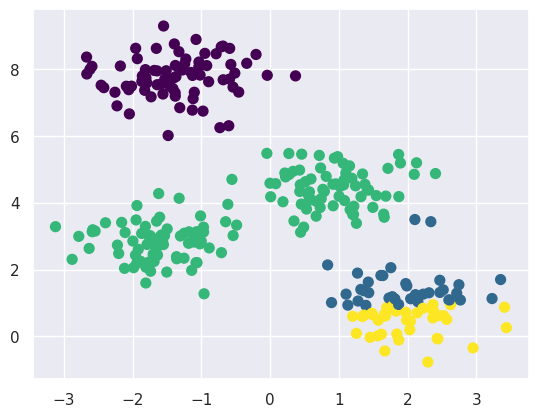

In [6]:
centers, labels = find_clusters(X, 4, rseed=0)
plt.scatter(X[:, 0], X[:, 1], c=labels,
            s=50, cmap='viridis');

Ici, l'approche E-M a convergé, mais n'a pas convergé vers une configuration globalement optimale. Pour cette raison, il est courant que l'algorithme soit exécuté pour plusieurs hypothèses de départ, comme le fait Scikit-Learn par défaut (défini par le paramètre ``n_init``, qui a la valeur 10 par défaut).

#### Le nombre de clusters doit être sélectionné à l'avance
Un autre défi courant avec les *k*-means est que vous devez lui dire combien de clusters vous attendez : il ne peut pas apprendre le nombre de clusters à partir des données.
Par exemple, si nous demandons à l'algorithme d'identifier six clusters, il s'empressera de trouver les six meilleurs clusters :

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


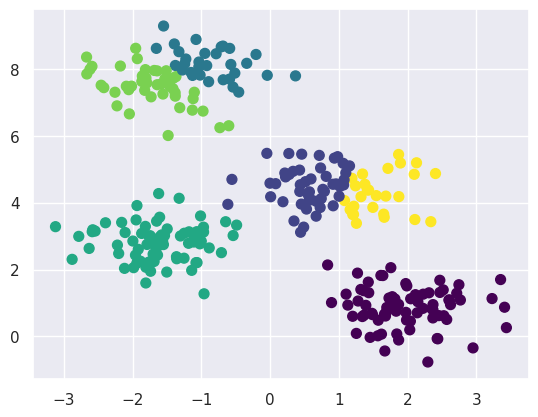

In [7]:
labels = KMeans(6, random_state=0).fit_predict(X)
plt.scatter(X[:, 0], X[:, 1], c=labels,
            s=50, cmap='viridis');

#### k-means est limité aux frontières linéaires des clusters
Les hypothèses du modèle fondamental de *k*-means (les points seront plus proches de leur propre centre de cluster que des autres) signifie que l'algorithme sera souvent inefficace si les clusters ont des géométries compliquées.

En particulier, les frontières entre les clusters *k*-means seront toujours linéaires, ce qui signifie qu'il échouera pour des frontières plus compliquées.
Considérons les données suivantes, ainsi que les étiquettes des clusters trouvées par l'approche *k*-means typique :

In [8]:
from sklearn.datasets import make_moons
X, y = make_moons(200, noise=.05, random_state=0)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


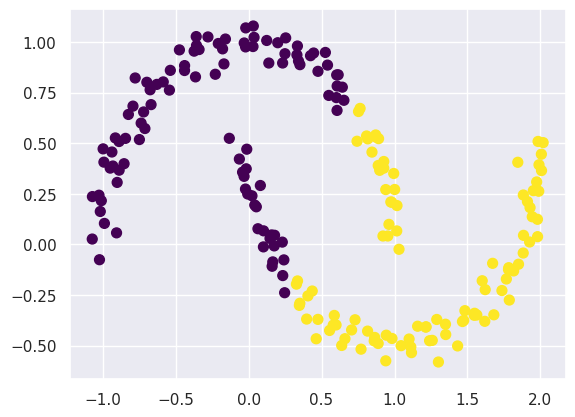

In [9]:
labels = KMeans(2, random_state=0).fit_predict(X)
plt.scatter(X[:, 0], X[:, 1], c=labels,
            s=50, cmap='viridis');

Cette situation rappelle les SVM, où nous avons utilisé une transformation à noyau pour projeter les données dans une dimension supérieure où une séparation linéaire est possible.
On pourrait imaginer d'utiliser la même astuce pour permettre à *k*-means de découvrir des frontières non linéaires.

Une version de ce *k*-means kernelisé est implémentée dans Scikit-Learn au sein de l'estimateur ``SpectralClustering``.
Il utilise le graphe des plus proches voisins pour calculer une représentation en plus haute dimension des données, puis attribue des étiquettes en utilisant un algorithme *k*-means :

/usr/local/lib/python3.10/dist-packages/sklearn/manifold/_spectral_embedding.py:274: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


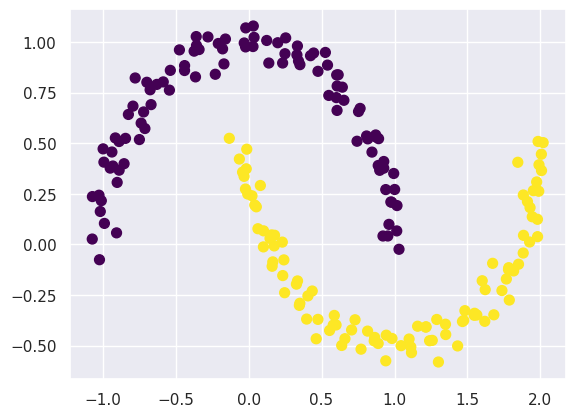

In [10]:
from sklearn.cluster import SpectralClustering
model = SpectralClustering(n_clusters=2, affinity='nearest_neighbors',
                           assign_labels='kmeans')
labels = model.fit_predict(X)
plt.scatter(X[:, 0], X[:, 1], c=labels,
            s=50, cmap='viridis');

Nous constatons qu'avec cette approche de transformation du noyau, le *k*-means kernelisé est capable de trouver les frontières non linéaires plus compliquées entre les clusters.

#### k-means peut être lent pour un grand nombre d'échantillons
Comme chaque itération de *k*-means doit accéder à chaque point de l'ensemble de données, l'algorithme peut être relativement lent lorsque le nombre d'échantillons augmente.
Vous pouvez vous demander si cette exigence d'utiliser toutes les données à chaque itération peut être relâchée ; par exemple, vous pourriez simplement utiliser un sous-ensemble des données pour mettre à jour les centres des clusters à chaque étape.
C'est l'idée derrière les algorithmes *k*-means basés sur des lots, dont une forme est implémentée dans ``sklearn.cluster.MiniBatchKMeans``.
L'interface est la même que pour les ``KMeans`` standards ; nous verrons un exemple de son utilisation dans la suite

## Exemples

En faisant attention à ces limitations de l'algorithme, nous pouvons utiliser *k*-means à notre avantage dans une grande variété de situations.
Nous allons maintenant examiner quelques exemples.

### Exemple 1 : k-means sur des chiffres

Pour commencer, voyons comment appliquer la méthode *k*-means sur les mêmes données simples de chiffres que nous avons aupravant
Ici, nous allons tenter d'utiliser *k*-means pour essayer d'identifier des chiffres similaires *sans utiliser les informations de l'étiquette originale* ; cela pourrait être similaire à une première étape dans l'extraction du sens d'un nouvel ensemble de données sur lequel vous n'avez aucune information *a priori* sur l'étiquette.

Nous allons commencer par charger les chiffres et ensuite trouver les clusters ``KMeans``.
Rappelons que les chiffres sont composés de 1 797 échantillons avec 64 caractéristiques, où chacune des 64 caractéristiques est la luminosité d'un pixel dans une image 8×8 :

In [11]:
from sklearn.datasets import load_digits
digits = load_digits()
digits.data.shape

(1797, 64)

In [12]:
kmeans = KMeans(n_clusters=10, random_state=0)
clusters = kmeans.fit_predict(digits.data)
kmeans.cluster_centers_.shape

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


(10, 64)

Le résultat est 10 clusters dans 64 dimensions.
Remarquez que les centres des clusters sont eux-mêmes des points à 64 dimensions, et peuvent être interprétés comme le chiffre "typique" au sein du cluster.
Voyons à quoi ressemblent ces centres de clusters :

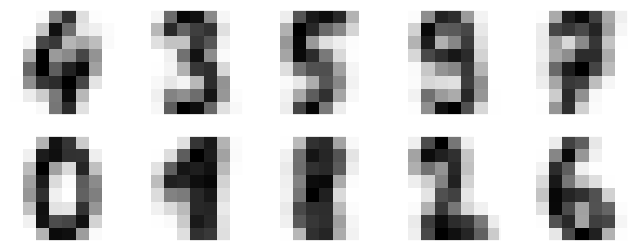

In [13]:
fig, ax = plt.subplots(2, 5, figsize=(8, 3))
centers = kmeans.cluster_centers_.reshape(10, 8, 8)
for axi, center in zip(ax.flat, centers):
    axi.set(xticks=[], yticks=[])
    axi.imshow(center, interpolation='nearest', cmap=plt.cm.binary)

Nous voyons que *même sans les étiquettes*, ``KMeans`` est capable de trouver des clusters dont les centres sont des chiffres reconnaissables, avec peut-être l'exception de 1 et 8.

Parce que *k*-means ne sait rien de l'identité du cluster, les étiquettes 0-9 peuvent être permutées.
Nous pouvons résoudre ce problème en faisant correspondre chaque étiquette de cluster appris avec les vraies étiquettes trouvées dans ceux-ci :

In [14]:
from scipy.stats import mode

labels = np.zeros_like(clusters)
for i in range(10):
    mask = (clusters == i)
    labels[mask] = mode(digits.target[mask])[0]

Nous pouvons maintenant vérifier la précision de notre classification non supervisée pour trouver des chiffres similaires dans les données :

In [15]:
from sklearn.metrics import accuracy_score
accuracy_score(digits.target, labels)

0.7935447968836951

Avec un simple algorithme *k*-means, nous avons découvert le groupement correct pour 80% des chiffres d'entrée !
Vérifions la matrice de confusion pour cela :

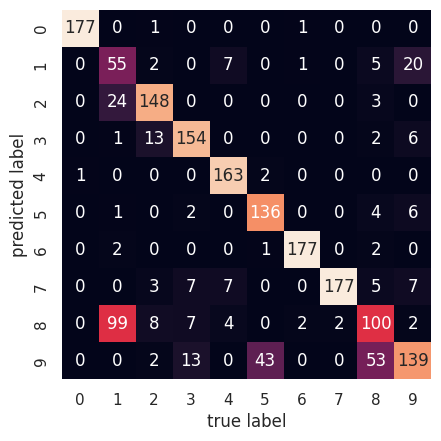

In [16]:
from sklearn.metrics import confusion_matrix
mat = confusion_matrix(digits.target, labels)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False,
            xticklabels=digits.target_names,
            yticklabels=digits.target_names)
plt.xlabel('true label')
plt.ylabel('predicted label');

### Exemple 2 : *k*-means pour la compression des couleurs

Une application intéressante du clustering est la compression des couleurs dans les images.
Par exemple, imaginez que vous avez une image avec des millions de couleurs.
Dans la plupart des images, un grand nombre de couleurs sont inutilisées et de nombreux pixels de l'image ont des couleurs similaires, voire identiques.

Prenons l'exemple de l'image présentée dans la figure suivante, qui provient du module Scikit-Learn ``datasets``.

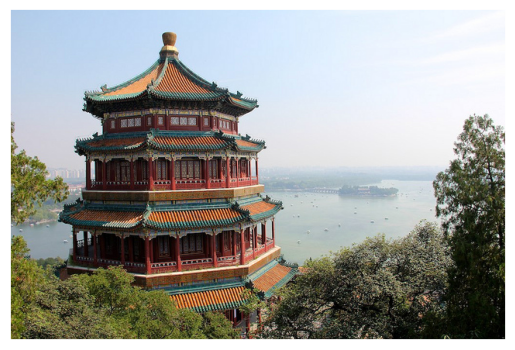

In [17]:
# Note: this requires the ``pillow`` package to be installed
from sklearn.datasets import load_sample_image
china = load_sample_image("china.jpg")
ax = plt.axes(xticks=[], yticks=[])
ax.imshow(china);

L'image elle-même est stockée dans un tableau tridimensionnel de taille ``(hauteur, largeur, RGB)``, contenant les contributions rouge/bleu/vert sous forme d'entiers de 0 à 255 :

In [18]:
china.shape

(427, 640, 3)

Nous pouvons voir cet ensemble de pixels comme un nuage de points dans un espace couleur tridimensionnel.
Nous allons remodeler les données en "[n_échantillons x n_caractéristiques]``, et redimensionner les couleurs pour qu'elles soient comprises entre 0 et 1 :

In [19]:
data = china / 255.0 # use 0...1 scale
data = data.reshape(427 * 640, 3)
data.shape

(273280, 3)

Nous pouvons visualiser ces pixels dans cet espace couleur, en utilisant un sous-ensemble de 10 000 pixels pour des raisons d'efficacité :

In [20]:
def plot_pixels(data, title, colors=None, N=10000):
    if colors is None:
        colors = data

    # choose a random subset
    rng = np.random.RandomState(0)
    i = rng.permutation(data.shape[0])[:N]
    colors = colors[i]
    R, G, B = data[i].T

    fig, ax = plt.subplots(1, 2, figsize=(16, 6))
    ax[0].scatter(R, G, color=colors, marker='.')
    ax[0].set(xlabel='Red', ylabel='Green', xlim=(0, 1), ylim=(0, 1))

    ax[1].scatter(R, B, color=colors, marker='.')
    ax[1].set(xlabel='Red', ylabel='Blue', xlim=(0, 1), ylim=(0, 1))

    fig.suptitle(title, size=20);

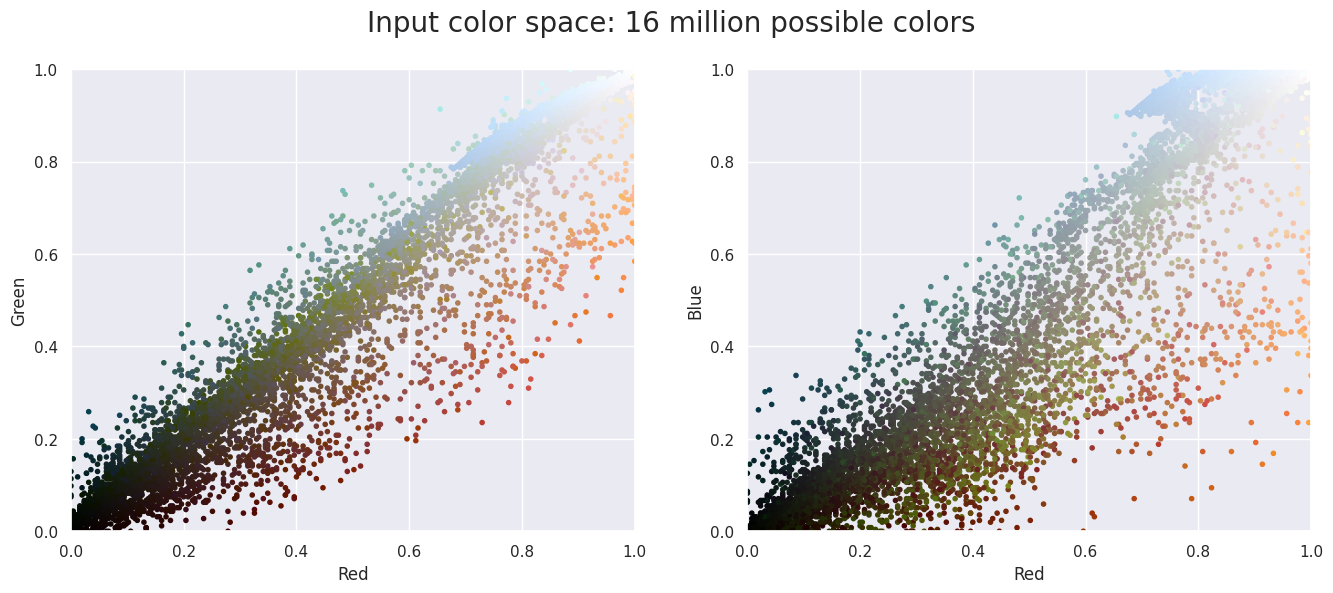

In [21]:
plot_pixels(data, title='Input color space: 16 million possible colors')

Réduisons maintenant ces 16 millions de couleurs à seulement 16 couleurs, en utilisant un clustering *k*-means dans l'espace des pixels.
Comme nous avons affaire à un très grand ensemble de données, nous allons utiliser le mini batch *k*-means, qui opère sur des sous-ensembles de données pour calculer le résultat beaucoup plus rapidement que l'algorithme *k*-means standard :

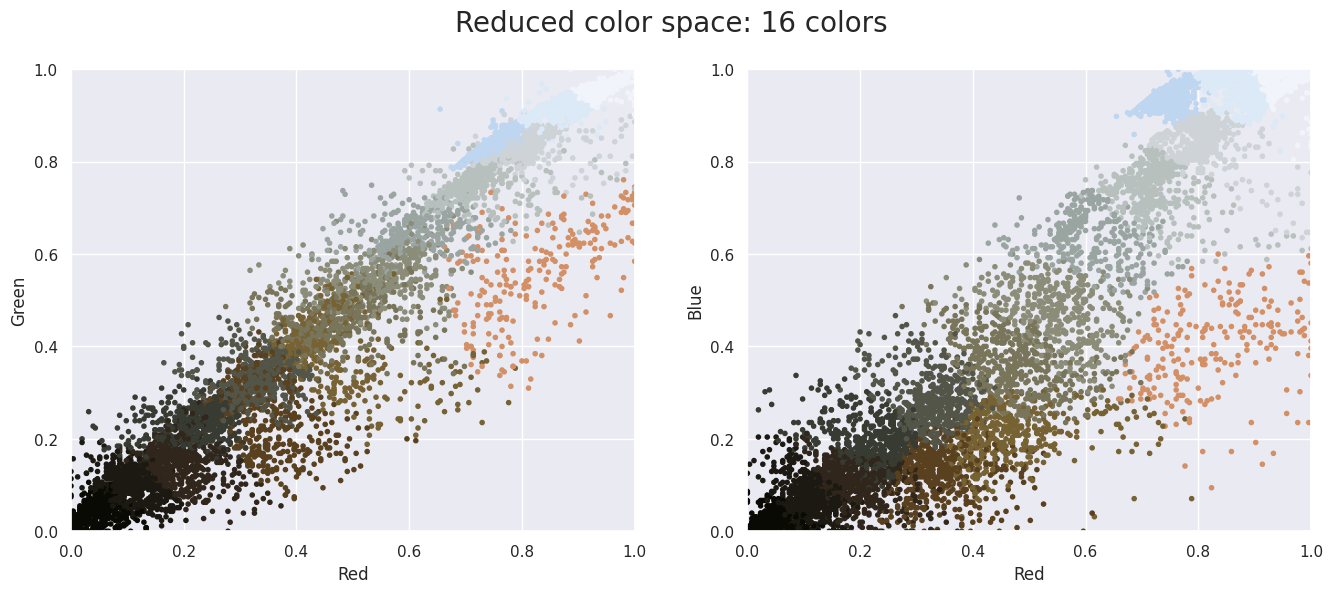

In [22]:
import warnings; warnings.simplefilter('ignore')  # Fix NumPy issues.

from sklearn.cluster import MiniBatchKMeans
kmeans = MiniBatchKMeans(16)
kmeans.fit(data)
new_colors = kmeans.cluster_centers_[kmeans.predict(data)]

plot_pixels(data, colors=new_colors,
            title="Reduced color space: 16 colors")

Le résultat est une recoloration des pixels originaux, où chaque pixel se voit attribuer la couleur de son centre de cluster le plus proche.
Le tracé de ces nouvelles couleurs dans l'espace image plutôt que dans l'espace pixel nous montre l'effet de cette opération :

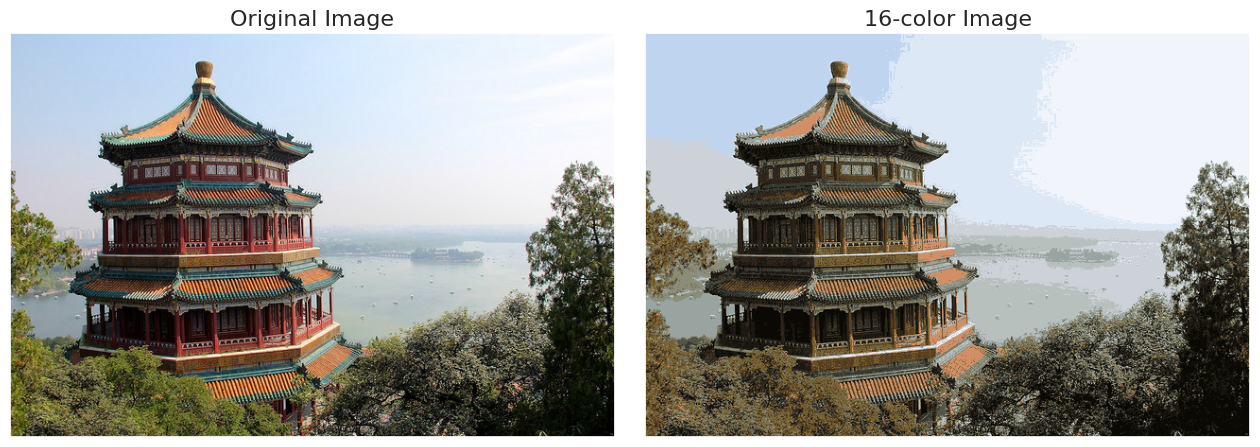

In [23]:
china_recolored = new_colors.reshape(china.shape)

fig, ax = plt.subplots(1, 2, figsize=(16, 6),
                       subplot_kw=dict(xticks=[], yticks=[]))
fig.subplots_adjust(wspace=0.05)
ax[0].imshow(china)
ax[0].set_title('Original Image', size=16)
ax[1].imshow(china_recolored)
ax[1].set_title('16-color Image', size=16);

Certains détails sont certainement perdus dans le panneau à droite, mais l'image globale reste facilement reconnaissable.
L'image de droite atteint un facteur de compression d'environ 1 million !
Bien qu'il s'agisse d'une application intéressante de *k*-means, il existe certainement de meilleures façons de compresser l'information dans les images.
Mais cet exemple montre qu'il est possible de sortir des sentiers battus avec des méthodes non supervisées comme les *k*-means.